# Análisis de Rendimiento: Minero Proof-of-Work

**Objetivo:** Comparar el rendimiento de tres modos de ejecución (Sequential, Concurrent, Parallel) con diferentes configuraciones de hilos y dificultades.

Este notebook puede analizar:
- Una sola carpeta de experimento (Experiment_*)
- Múltiples carpetas (promedios entre ejecuciones de diferentes PCs)

## Diseño Experimental
- **Modos:** Sequential (1 hilo), Concurrent (2/4/8 hilos con CPU pinning), Parallel (2/4/8 hilos multi-core)
- **Dificultades:** LOW (20 bits), MED (22 bits), HIGH (24 bits)
- **Configuraciones:** 21 combinaciones
- **Repeticiones:** 5 por configuración
- **Total de ejecuciones por experimento:** 105

## Índice
1. [Carga de Datos](#carga)
2. [Estadísticas Descriptivas](#estadisticas)
3. [Análisis Comparativo por Modo](#comparativo)
4. [Análisis por Dificultad](#dificultad)
5. [Análisis por Número de Hilos](#hilos)
6. [Speedup y Eficiencia](#speedup)
7. [Análisis Estadístico](#estadistico)
8. [Visualizaciones](#visualizaciones)
9. [Conclusiones](#conclusiones)

## 1. Carga de Datos

Cargamos todos los resultados experimentales desde una o más carpetas de experimento.

### 1.1. Configuración de Carpetas

Especifica las carpetas de experimento a analizar:
- `None`: Buscar automáticamente todas las carpetas `Experiment_*` en `results/`
- `[\"Experiment_...\"]`: Lista específica de carpetas
- `"latest"`: Usar únicamente la carpeta más reciente

In [30]:
# Configuración: Carpetas de experimento a analizar
# Opciones:
#   None: Todas las carpetas Experiment_* disponibles
#   "latest": Únicamente la carpeta más reciente
#   ["Experiment_...", ...]: Lista específica

EXPERIMENT_FOLDERS = None  # Analizar todas las carpetas disponibles
# EXPERIMENT_FOLDERS = "latest"  # Solo la más reciente
# EXPERIMENT_FOLDERS = ["Experiment_20251202_143025_AMD_Ryzen_7_32GB"]  # Específica

print(f"Configuración: {EXPERIMENT_FOLDERS}")

Configuración: None


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [32]:
# Rutas del proyecto
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
RESULTS_DIR = ROOT / 'results'

print(f"Directorio raíz: {ROOT}")
print(f"Directorio de resultados: {RESULTS_DIR}")

Directorio raíz: c:\d\Proyectos_programacion\SO_Proyecto_Final
Directorio de resultados: c:\d\Proyectos_programacion\SO_Proyecto_Final\results


In [33]:
# Detectar carpetas de experimento disponibles
experiment_folders = sorted([d for d in RESULTS_DIR.iterdir() if d.is_dir() and d.name.startswith('Experiment_')])

print(f"Carpetas de experimento encontradas: {len(experiment_folders)}")
for folder in experiment_folders:
    print(f"  - {folder.name}")

if len(experiment_folders) == 0:
    print("\n⚠️ No se encontraron carpetas de experimento.")
    print("   Ejecuta primero los experimentos con: .\\scripts\\run_all_modes.ps1")
else:
    # Determinar qué carpetas analizar
    if EXPERIMENT_FOLDERS == "latest":
        folders_to_analyze = [experiment_folders[-1]]
        print(f"\n🔍 Analizando únicamente la carpeta más reciente: {folders_to_analyze[0].name}")
    elif EXPERIMENT_FOLDERS is None:
        folders_to_analyze = experiment_folders
        print(f"\n🔍 Analizando todas las carpetas ({len(folders_to_analyze)})")
    else:
        folders_to_analyze = [RESULTS_DIR / name for name in EXPERIMENT_FOLDERS if (RESULTS_DIR / name).exists()]
        print(f"\n🔍 Analizando carpetas específicas: {len(folders_to_analyze)}")
        for folder in folders_to_analyze:
            print(f"  - {folder.name}")
    
    # Cargar datos de todas las carpetas seleccionadas
    dfs = []
    total_files = 0
    
    for exp_folder in folders_to_analyze:
        raw_dir = exp_folder / 'raw'
        if not raw_dir.exists():
            print(f"\n⚠️ Carpeta raw/ no encontrada en {exp_folder.name}")
            continue
        
        csv_files = list(raw_dir.glob('exp_*.csv'))
        print(f"\n{exp_folder.name}: {len(csv_files)} archivos CSV")
        total_files += len(csv_files)
        
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                # Extraer información del nombre del archivo
                filename = csv_file.stem
                parts = filename.split('_')
                if len(parts) >= 4:
                    df['experiment_id'] = '_'.join(parts[:4])  # exp_mode_threads_difficulty
                else:
                    df['experiment_id'] = '_'.join(parts[:3])  # fallback
                df['run_id'] = filename
                df['experiment_folder'] = exp_folder.name
                dfs.append(df)
            except Exception as e:
                print(f"  ⚠️ Error al cargar {csv_file.name}: {e}")
    
    if dfs:
        all_data = pd.concat(dfs, ignore_index=True)
        
        # Normalizar nombres de columnas
        if 'elapsed_s' in all_data.columns:
            all_data['elapsed_time_s'] = all_data['elapsed_s']
        if 'hashes_per_second' in all_data.columns:
            all_data['throughput_hashes_per_sec'] = all_data['hashes_per_second']
        
        print(f"\n✅ Datos cargados: {len(all_data)} registros de {total_files} archivos")
        print(f"   Carpetas analizadas: {len(folders_to_analyze)}")
        print(f"   Experimentos por carpeta: {all_data.groupby('experiment_folder').size().to_dict()}")
        print(f"\nColumnas disponibles: {list(all_data.columns)}")
    else:
        print("\n❌ No se pudieron cargar los datos")

Carpetas de experimento encontradas: 2
  - Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB
  - Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB

🔍 Analizando todas las carpetas (2)

Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB: 190 archivos CSV

Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB: 190 archivos CSV

Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB: 190 archivos CSV

✅ Datos cargados: 380 registros de 380 archivos
   Carpetas analizadas: 2
   Experimentos por carpeta: {'Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB': 190, 'Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB': 190}

Columnas disponibles: ['experiment_id', 'mode', 'difficulty', 'threads', 'affinity', 'found', 'nonce', 'total_hashes', 'elapsed_s', 'cpu_time_s', 'memory_mb', 'hashes_per_second', 'run_id', 'experiment_folder', 'elapsed_time_s', 'through

In [34]:
# Vista preliminar de los datos
if 'all_data' in locals():
    print("Primeras filas del dataset:")
    display(all_data.head(10))
    
    print(f"\nDimensiones: {all_data.shape[0]} filas × {all_data.shape[1]} columnas")
    print(f"\nCarpetas de experimento: {all_data['experiment_folder'].nunique()}")
    print(f"Experimentos únicos: {all_data['experiment_id'].nunique()}")
    
    if all_data['experiment_folder'].nunique() > 1:
        print(f"\nDistribución por carpeta:")
        display(all_data.groupby('experiment_folder')['experiment_id'].value_counts().head(20))

Primeras filas del dataset:


,experiment_id,mode,difficulty,threads,affinity,found,nonce,total_hashes,elapsed_s,cpu_time_s,memory_mb,hashes_per_second,run_id,experiment_folder,elapsed_time_s,throughput_hashes_per_sec
0,exp_con_10t_high,concurrent,24,10,True,True,1.291272e+19,12687200,16.125000,15.609400,7.95312,786801.0,exp_con_10t_high_run_20251205T085707Z_rep1,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,16.125000,786801.0
1,exp_con_10t_high,concurrent,24,10,True,True,1.291272e+19,13093425,16.617000,15.984400,7.96484,787953.0,exp_con_10t_high_run_20251205T085728Z_rep2,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,16.617000,787953.0
2,exp_con_10t_high,concurrent,24,10,True,True,1.291272e+19,12817037,16.800300,16.140600,7.96875,762904.0,exp_con_10t_high_run_20251205T085749Z_rep3,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,16.800300,762904.0
3,exp_con_10t_high,concurrent,24,10,True,True,1.291272e+19,12775334,16.778900,16.140600,7.94531,761392.0,exp_con_10t_high_run_20251205T085811Z_rep4,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,16.778900,761392.0
4,exp_con_10t_high,concurrent,24,10,True,True,1.291272e+19,12700774,16.538300,15.937500,7.94531,767963.0,exp_con_10t_high_run_20251205T085832Z_rep5,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,16.538300,767963.0
5,exp_con_10t_low,concurrent,20,10,True,True,1.106805e+19,221059,0.318358,0.328125,7.93359,694373.0,exp_con_10t_low_run_20251205T085853Z_rep1,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,0.318358,694373.0
6,exp_con_10t_low,concurrent,20,10,True,True,1.106805e+19,82570,0.125548,0.140625,7.94141,657678.0,exp_con_10t_low_run_20251205T085859Z_rep2,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,0.125548,657678.0
7,exp_con_10t_low,concurrent,20,10,True,True,1.106805e+19,84821,0.125424,0.125000,7.91797,676275.0,exp_con_10t_low_run_20251205T085903Z_rep3,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,0.125424,676275.0
8,exp_con_10t_low,concurrent,20,10,True,True,1.106805e+19,85289,0.126378,0.109375,7.92578,674871.0,exp_con_10t_low_run_20251205T085908Z_rep4,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,0.126378,674871.0
9,exp_con_10t_low,concurrent,20,10,True,True,1.106805e+19,83127,0.136377,0.140625,7.92969,609539.0,exp_con_10t_low_run_20251205T085913Z_rep5,Experiment_20251205_085707_AMD_Ryzen_7_5700X_8...,0.136377,609539.0



Dimensiones: 380 filas × 16 columnas

Carpetas de experimento: 2
Experimentos únicos: 38

Distribución por carpeta:


experiment_folder                                                    experiment_id   
Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB  exp_con_10t_high    5
                                                                     exp_con_10t_low     5
                                                                     exp_con_10t_med     5
                                                                     exp_con_20t_low     5
                                                                     exp_con_20t_med     5
                                                                     exp_con_2t_high     5
                                                                     exp_con_2t_low      5
                                                                     exp_con_2t_med      5
                                                                     exp_con_30t_low     5
                                                                     exp_con_40t_low     5
    

### 1.2. Agregación de Múltiples Experimentos

Si hay múltiples carpetas de experimento, agregamos los datos calculando promedios por configuración.

In [35]:
if 'all_data' in locals() and all_data['experiment_folder'].nunique() > 1:
    print("=== AGREGACIÓN DE MÚLTIPLES CARPETAS ===\n")
    print(f"Carpetas detectadas: {all_data['experiment_folder'].nunique()}")
    print(f"Total de registros: {len(all_data)}\n")
    
    # Mostrar distribución de ejecuciones por carpeta y configuración
    print("Distribución de ejecuciones por carpeta:")
    dist = all_data.groupby(['experiment_folder', 'experiment_id']).size().unstack(fill_value=0)
    display(dist)
    
    # Calcular estadísticas agregadas por configuración
    print("\n📊 Calculando promedios entre carpetas de experimento...")
    
    # Agrupar por configuración y calcular estadísticas
    agg_data = all_data.groupby(['experiment_id', 'mode', 'difficulty', 'threads', 'affinity']).agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'count'],
        'elapsed_time_s': ['mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'memory_mb': ['mean', 'std'],
        'total_hashes': ['mean', 'std']
    }).reset_index()
    
    # Aplanar nombres de columnas
    agg_data.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in agg_data.columns.values]
    
    print(f"✅ Datos agregados: {len(agg_data)} configuraciones únicas")
    print(f"   Promediados desde {all_data['experiment_folder'].nunique()} carpetas")
    print(f"\nColumnas agregadas:")
    display(agg_data.head(10))
    
    # Mantener all_data original para análisis detallados
    all_data_detailed = all_data.copy()
    
    # Crear versión simplificada con promedios para análisis principal
    all_data_aggregated = agg_data.rename(columns={
        'throughput_hashes_per_sec_mean': 'throughput_hashes_per_sec',
        'throughput_hashes_per_sec_std': 'throughput_std',
        'elapsed_time_s_mean': 'elapsed_time_s',
        'elapsed_time_s_std': 'elapsed_time_std',
        'cpu_time_s_mean': 'cpu_time_s',
        'memory_mb_mean': 'memory_mb',
        'total_hashes_mean': 'total_hashes',
        'throughput_hashes_per_sec_count': 'n_samples'
    })
    
    print(f"\n💡 Usando datos agregados para análisis. Desviaciones estándar disponibles.")
    print(f"   Variables: *_std contienen desviación estándar entre carpetas")
    print(f"   all_data_detailed: Datos originales sin agregar")
    print(f"   all_data_aggregated: Datos promediados por configuración")
    
elif 'all_data' in locals():
    print("=== CARPETA ÚNICA ===")
    print("Analizando datos de una sola carpeta de experimento.")
    print("No se requiere agregación.")
    all_data_detailed = all_data.copy()
    all_data_aggregated = all_data.copy()
    all_data_aggregated['n_samples'] = 1

=== AGREGACIÓN DE MÚLTIPLES CARPETAS ===

Carpetas detectadas: 2
Total de registros: 380

Distribución de ejecuciones por carpeta:


experiment_id,exp_con_10t_high,exp_con_10t_low,exp_con_10t_med,exp_con_20t_low,exp_con_20t_med,exp_con_2t_high,exp_con_2t_low,exp_con_2t_med,exp_con_30t_low,exp_con_40t_low,...,exp_par_32t_low,exp_par_4t_high,exp_par_4t_low,exp_par_4t_med,exp_par_8t_high,exp_par_8t_low,exp_par_8t_med,exp_seq_high_run,exp_seq_low_run,exp_seq_med_run
experiment_folder,,,,,,,,,,,,,,,,,,,,,
Experiment_20251205_085707_AMD_Ryzen_7_5700X_8-Core_Processor__32GB,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Experiment_20251205_115538_11th_Gen_Intel_R_Core_TM_i5-11400H_2_70GHz_8GB,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5



📊 Calculando promedios entre carpetas de experimento...
✅ Datos agregados: 38 configuraciones únicas
   Promediados desde 2 carpetas

Columnas agregadas:


,experiment_id,mode,difficulty,threads,affinity,throughput_hashes_per_sec_mean,throughput_hashes_per_sec_std,throughput_hashes_per_sec_count,elapsed_time_s_mean,elapsed_time_s_std,cpu_time_s_mean,cpu_time_s_std,memory_mb_mean,memory_mb_std,total_hashes_mean,total_hashes_std
0,exp_con_10t_high,concurrent,24,10,True,683798.0,96798.805328,10,19.074420,2.713926,18.345310,2.542649,7.948046,0.020258,12807678.6,179559.632196
1,exp_con_10t_low,concurrent,20,10,True,548612.6,129317.709118,10,0.179839,0.073541,0.173437,0.069663,7.922657,0.016033,98002.0,49961.093905
2,exp_con_10t_med,concurrent,22,10,True,548272.3,212790.592776,10,0.234238,0.078256,0.209375,0.077672,7.922267,0.020460,126223.5,66030.760075
3,exp_con_20t_low,concurrent,20,20,True,623070.2,157436.768916,10,0.450651,0.161913,0.429688,0.162588,7.994922,0.025253,276811.0,114701.974282
4,exp_con_20t_med,concurrent,22,20,True,592461.4,176429.139621,10,0.367981,0.197337,0.337500,0.141529,7.991798,0.027028,199824.4,69985.445317
5,exp_con_2t_high,concurrent,24,2,True,719118.0,96446.235551,10,13.311840,1.779218,12.921880,1.595666,7.701561,0.295422,9418410.5,21958.927561
6,exp_con_2t_low,concurrent,20,2,True,688515.7,113971.280401,10,0.430346,0.064541,0.414062,0.058579,7.849219,0.092990,290025.9,14540.483741
7,exp_con_2t_med,concurrent,22,2,True,676636.2,143454.218055,10,0.445346,0.087773,0.414062,0.066393,7.887891,0.018511,290158.5,13333.452143
8,exp_con_30t_low,concurrent,20,30,True,594594.2,165612.273950,10,0.530261,0.201266,0.517188,0.202717,8.048827,0.019767,336188.0,177946.367441
9,exp_con_40t_low,concurrent,20,40,True,605206.6,147183.064797,10,0.780218,0.385582,0.750000,0.394460,8.068750,0.044699,506315.5,361917.211454



💡 Usando datos agregados para análisis. Desviaciones estándar disponibles.
   Variables: *_std contienen desviación estándar entre carpetas
   all_data_detailed: Datos originales sin agregar
   all_data_aggregated: Datos promediados por configuración


## 2. Estadísticas Descriptivas

Análisis descriptivo de las métricas principales.

In [36]:
# Resumen estadístico general
if 'all_data' in locals():
    metrics = ['elapsed_time_s', 'throughput_hashes_per_sec', 'cpu_time_s', 'memory_mb']
    
    print("=== RESUMEN ESTADÍSTICO GENERAL ===")
    print("\nMétricas principales:")
    display(all_data[metrics].describe())
    
    # Resumen por modo de ejecución
    print("\n=== RESUMEN POR MODO DE EJECUCIÓN ===")
    for metric in ['throughput_hashes_per_sec', 'elapsed_time_s']:
        print(f"\n{metric.upper()}:")
        summary = all_data.groupby('mode')[metric].agg(['count', 'mean', 'std', 'min', 'max'])
        display(summary)

=== RESUMEN ESTADÍSTICO GENERAL ===

Métricas principales:


,elapsed_time_s,throughput_hashes_per_sec,cpu_time_s,memory_mb
count,380.000000,3.800000e+02,380.000000,380.000000
mean,4.760637,1.829735e+06,14.531414,7.902508
std,10.172673,1.495573e+06,32.565364,0.175157
min,0.013464,1.157760e+05,0.000000,7.152340
25%,0.269780,6.586260e+05,0.468750,7.851560
50%,0.428967,8.845035e+05,1.250000,7.917970
75%,6.311585,3.126330e+06,6.683597,7.992190
max,62.911300,5.349590e+06,205.812000,8.238280



=== RESUMEN POR MODO DE EJECUCIÓN ===

THROUGHPUT_HASHES_PER_SEC:


,count,mean,std,min,max
mode,,,,,
concurrent,160,6.433092e+05,1.368274e+05,115776.0,815630.0
parallel,190,3.014382e+06,1.283177e+06,935099.0,5349590.0
sequential,30,6.545709e+05,9.452071e+04,514857.0,833908.0



ELAPSED_TIME_S:


,count,mean,std,min,max
mode,,,,,
concurrent,160,7.596539,14.434670,0.095613,62.91130
parallel,190,2.765740,4.372613,0.013464,17.72500
sequential,30,2.270175,2.926476,0.210775,6.68082


In [37]:
# Distribución de configuraciones
if 'all_data' in locals():
    print("=== CONFIGURACIONES EXPERIMENTALES ===")
    
    config_summary = all_data.groupby(['mode', 'threads', 'difficulty']).agg({
        'run_id': 'count',
        'throughput_hashes_per_sec': ['mean', 'std'],
        'elapsed_time_s': ['mean', 'std']
    }).round(2)
    
    config_summary.columns = ['n_runs', 'throughput_mean', 'throughput_std', 'time_mean', 'time_std']
    display(config_summary)

=== CONFIGURACIONES EXPERIMENTALES ===


n_runs  throughput_mean  throughput_std  \
mode       threads difficulty                                            
concurrent 2       20              10         688515.7       113971.28   
                   22              10         676636.2       143454.22   
                   24              10         719118.0        96446.24   
           4       20              10         623853.6       124907.32   
                   22              10         656021.9       147826.72   
                   24              10         680951.9        95947.12   
           8       20              10         666525.5        81552.64   
                   22              10         684900.3        67830.97   
                   24              10         700409.5        77356.07   
           10      20              10         548612.6       129317.71   
                   22              10         548272.3       212790.59   
                   24              10         683798.0        96798.81   
           20      20              10         623070.2       157436.77   
                   22              10         592461.4       176429.14   
           30      20              10         594594.2       165612.27   
           40      20              10         605206.6       147183.06   
parallel   2       20              10        1044701.5        79786.83   
                   22              10        1078650.9        71611.71   
                   24              10        1179021.0        64333.30   
           4       20              10        1915715.0        71426.63   
                   22              10        2129116.0       367566.20   
                   24              10        2039831.0       153871.11   
           8       20              10        2945851.0       341845.65   
                   22              10        3112620.0       230908.25   
                   24              10        3265384.0       467004.95   
           12      20              10        3934459.0       688340.02   
                   22              10        3915902.0       753409.32   
                   24              10        4149603.0       680474.02   
           16      20              10        4010441.0       663446.13   
                   22              10        4268308.0       828083.42   
                   24              10        4180431.0      1182301.40   
           20      20              10        2819720.0      1009886.17   
                   22              10        2855914.0       738433.68   
           24      20              10        4349286.0       855409.19   
           32      20              10        4078300.0      1082141.77   
sequential 1       20              10         597943.7        71833.07   
                   22              10         608983.6        63004.14   
                   24              10         756785.4        46665.10   

                               time_mean  time_std  
mode       threads difficulty                       
concurrent 2       20               0.43      0.06  
                   22               0.45      0.09  
                   24              13.31      1.78  
           4       20               0.95      0.16  
                   22               0.93      0.19  
                   24              27.83      3.73  
           8       20               0.91      0.12  
                   22               1.65      0.21  
                   24              53.46      6.06  
           10      20               0.18      0.07  
                   22               0.23      0.08  
                   24              19.07      2.71  
           20      20               0.45      0.16  
                   22               0.37      0.20  
           30      20               0.53      0.20  
           40      20               0.78      0.39  
parallel   2       20               0.27      0.02  
                   22               0.27      0.02  
          

## 3. Análisis Comparativo por Modo 

Comparación detallada entre los tres modos de ejecución.

In [38]:
# Crear tabla comparativa
if 'all_data' in locals():
    comparison = all_data.groupby('mode').agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max'],
        'elapsed_time_s': ['mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'memory_mb': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    comparison.columns = ['_'.join(col) for col in comparison.columns]
    comparison = comparison.rename(columns={'run_id_count': 'n_executions'})
    
    print("=== COMPARACIÓN ENTRE MODOS ===")
    display(comparison)
    
    # Calcular mejora relativa respecto a sequential
    if 'sequential' in comparison.index:
        baseline = comparison.loc['sequential', 'throughput_hashes_per_sec_mean']
        comparison['speedup_vs_sequential'] = (comparison['throughput_hashes_per_sec_mean'] / baseline).round(2)
        
        print("\n=== SPEEDUP vs SEQUENTIAL ===")
        display(comparison[['throughput_hashes_per_sec_mean', 'speedup_vs_sequential']])

=== COMPARACIÓN ENTRE MODOS ===


,throughput_hashes_per_sec_mean,throughput_hashes_per_sec_std,throughput_hashes_per_sec_min,throughput_hashes_per_sec_max,elapsed_time_s_mean,elapsed_time_s_std,cpu_time_s_mean,cpu_time_s_std,memory_mb_mean,memory_mb_std,n_executions
mode,,,,,,,,,,,
concurrent,643309.24,136827.41,115776.0,815630.0,7.60,14.43,7.40,14.12,7.87,0.21,160
parallel,3014381.81,1283176.77,935099.0,5349590.0,2.77,4.37,22.48,42.74,7.94,0.15,190
sequential,654570.90,94520.71,514857.0,833908.0,2.27,2.93,2.27,2.92,7.84,0.01,30



=== SPEEDUP vs SEQUENTIAL ===


,throughput_hashes_per_sec_mean,speedup_vs_sequential
mode,,
concurrent,643309.24,0.98
parallel,3014381.81,4.61
sequential,654570.90,1.00


=== ANÁLISIS POR NÚMERO DE HILOS ===


throughput_mean  throughput_std  n_runs
mode       threads                                         
concurrent 2              694756.63       116772.95      30
           4              653609.13       122661.89      30
           8              683945.10        74481.38      30
           10             593560.97       162363.75      30
           20             607765.80       163499.02      20
           30             594594.20       165612.27      10
           40             605206.60       147183.06      10
parallel   2             1100791.13        90641.02      30
           4             2028220.67       242449.35      30
           8             3107951.67       371635.24      30
           12            3999988.00       691770.19      30
           16            4153060.00       891670.08      30
           20            2837817.00       861239.60      20
           24            4349286.00       855409.19      10
           32            4078300.00      1082141.77      10
sequential 1              654570.90        94520.71      30

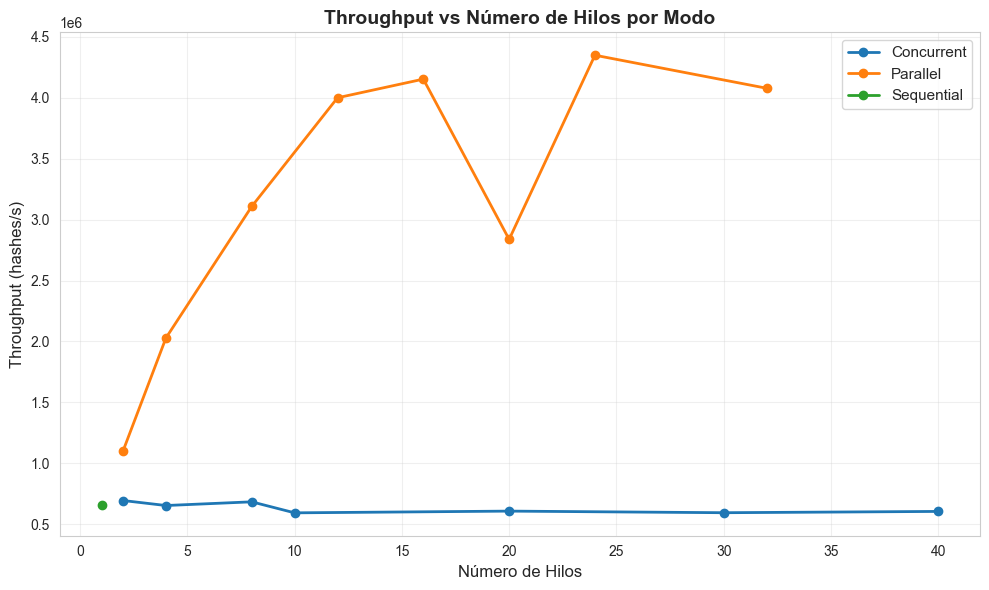

In [39]:
# Análisis por número de hilos
if 'all_data' in locals():
    print("=== ANÁLISIS POR NÚMERO DE HILOS ===")
    
    thread_analysis = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    thread_analysis.columns = ['throughput_mean', 'throughput_std', 'n_runs']
    display(thread_analysis)
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 6))
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        thread_means = mode_data.groupby('threads')['throughput_hashes_per_sec'].mean()
        ax.plot(thread_means.index, thread_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    ax.set_xlabel('Número de Hilos', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput vs Número de Hilos por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Speedup y Eficiencia

Cálculo de métricas de paralelización.

## 4.1. Análisis por Dificultad

Evaluación del impacto de la dificultad en el rendimiento por modo.

=== ANÁLISIS POR DIFICULTAD ===



throughput_hashes_per_sec_mean  \
mode       difficulty                                   
concurrent 20                               621482.63   
           22                               631658.42   
           24                               696069.35   
parallel   20                              3137309.19   
           22                              2893418.48   
           24                              2962854.00   
sequential 20                               597943.70   
           22                               608983.60   
           24                               756785.40   

                       throughput_hashes_per_sec_std  \
mode       difficulty                                  
concurrent 20                              135178.90   
           22                              159742.72   
           24                               89735.69   
parallel   20                             1298948.41   
           22                             1211229.57   
           24                             1348660.27   
sequential 20                               71833.07   
           22                               63004.14   
           24                               46665.10   

                       throughput_hashes_per_sec_min  \
mode       difficulty                                  
concurrent 20                               273543.0   
           22                               115776.0   
           24                               543674.0   
parallel   20                               951263.0   
           22                               935099.0   
           24                              1030940.0   
sequential 20                               514857.0   
           22                               532773.0   
           24                               714521.0   

                       throughput_hashes_per_sec_max  elapsed_time_s_mean  \
mode       difficulty                                                       
concurrent 20                               808861.0                 0.61   
           22                               811190.0                 0.73   
           24                               815630.0                28.42   
parallel   20                              5230650.0                 0.25   
           22                              5128130.0                 0.32   
           24                              5349590.0                 9.73   
sequential 20                               674873.0                 0.24   
           22                               681922.0                 0.24   
           24                               833908.0                 6.33   

                       elapsed_time_s_std  run_id_count  
mode       difficulty                                    
concurrent 20                        0.32            70  
           22                        0.55            50  
           24                       16.00            40  
parallel   20                        0.13            80  
           22                        0.18            60  
           24                        2.55            50  
sequential 20                        0.03            10  
           22                        0.02            10  
           24                        0.38            10

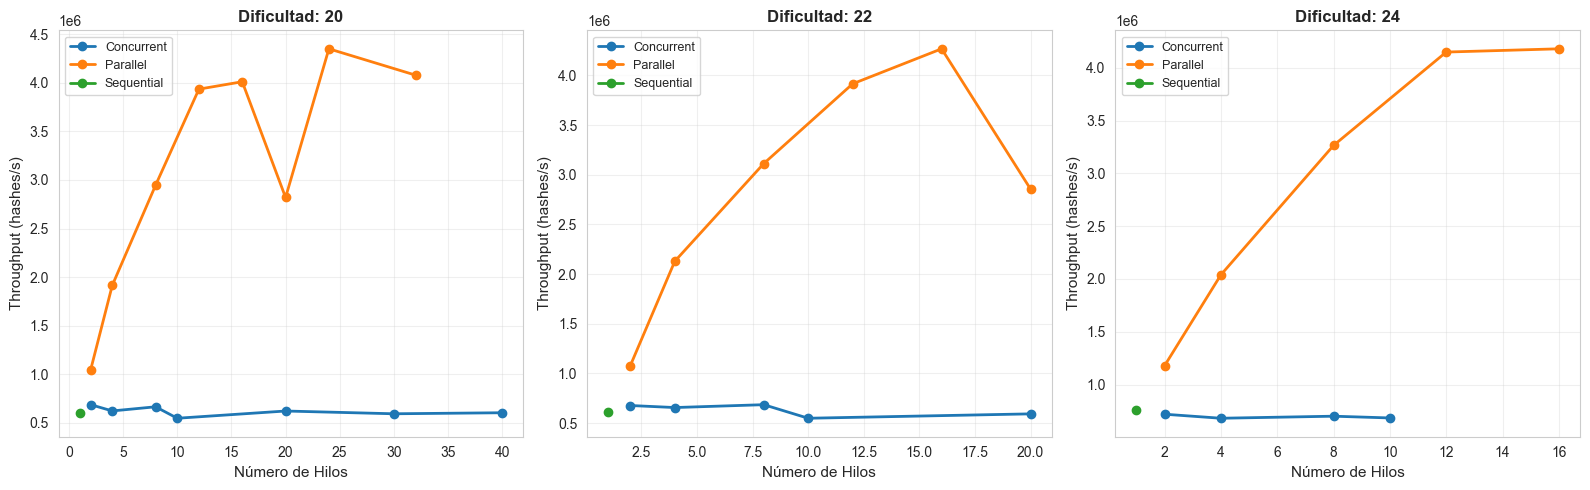


=== IMPACTO DE DIFICULTAD EN SPEEDUP ===

Modo: PARALLEL


difficulty,20,22,24
throughput_hashes_per_sec,3.137309e+06,2.893418e+06,2962854.0


Coeficiente de variación: 42.93% (promedio entre dificultades)

Modo: CONCURRENT


difficulty,20,22,24
throughput_hashes_per_sec,621482.628571,631658.42,696069.35


Coeficiente de variación: 19.98% (promedio entre dificultades)


In [40]:
# Análisis del impacto de la dificultad en el rendimiento
if 'all_data' in locals():
    print("=== ANÁLISIS POR DIFICULTAD ===\n")
    
    difficulty_analysis = all_data.groupby(['mode', 'difficulty']).agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max'],
        'elapsed_time_s': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    difficulty_analysis.columns = ['_'.join(col) for col in difficulty_analysis.columns]
    display(difficulty_analysis)
    
    # Gráfica comparativa por dificultad
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    difficulties = sorted(all_data['difficulty'].unique())
    
    for idx, difficulty in enumerate(difficulties):
        ax = axes[idx]
        diff_data = all_data[all_data['difficulty'] == difficulty]
        
        for mode in diff_data['mode'].unique():
            mode_data = diff_data[diff_data['mode'] == mode]
            thread_means = mode_data.groupby('threads')['throughput_hashes_per_sec'].mean()
            ax.plot(thread_means.index, thread_means.values, marker='o', linewidth=2, label=mode.capitalize())
        
        ax.set_xlabel('Número de Hilos', fontsize=11)
        ax.set_ylabel('Throughput (hashes/s)', fontsize=11)
        ax.set_title(f'Dificultad: {difficulty}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis estadístico: ¿La dificultad afecta el speedup?
    print("\n=== IMPACTO DE DIFICULTAD EN SPEEDUP ===")
    for mode in ['parallel', 'concurrent']:
        if mode in all_data['mode'].values:
            print(f"\nModo: {mode.upper()}")
            mode_diff = all_data[all_data['mode'] == mode].groupby('difficulty')['throughput_hashes_per_sec'].mean()
            display(mode_diff.to_frame().T)
            
            # Coeficiente de variación
            cv = (all_data[all_data['mode'] == mode].groupby('difficulty')['throughput_hashes_per_sec'].std() / 
                  all_data[all_data['mode'] == mode].groupby('difficulty')['throughput_hashes_per_sec'].mean() * 100)
            print(f"Coeficiente de variación: {cv.mean():.2f}% (promedio entre dificultades)")


## 4.2. Análisis de Punto de Saturación

Identificación del punto exacto donde agregar más hilos deja de ser efectivo.

=== ANÁLISIS DE PUNTO DE SATURACIÓN ===

MODO PARALLEL - Análisis marginal:


,threads,throughput_hashes_per_sec,speedup,efficiency_pct,marginal_improvement,efficiency_drop
7,2,1048341.60,1.68,83.8,NaN,NaN
8,4,2067599.33,3.31,82.6,509628.87,-1.2
9,8,3342920.00,5.34,66.8,318830.17,-15.8
10,12,4665874.67,7.46,62.2,330738.67,-4.6
11,16,4980212.00,7.96,49.8,78584.33,-12.4
12,20,3599835.00,5.75,28.8,-345094.25,-21.0
13,24,5160072.00,8.25,34.4,390059.25,5.6
14,32,5049092.00,8.07,25.2,-13872.50,-9.2



🎯 PUNTO DE SATURACIÓN DETECTADO: 16 hilos
   Criterio: Mejora marginal < 100,000 hashes/s por hilo adicional

✅ MEJOR CONFIGURACIÓN EFICIENTE (>50% eficiencia):
   Hilos: 12
   Throughput: 4,665,875 hashes/s
   Speedup: 7.46×
   Eficiencia: 62.2%


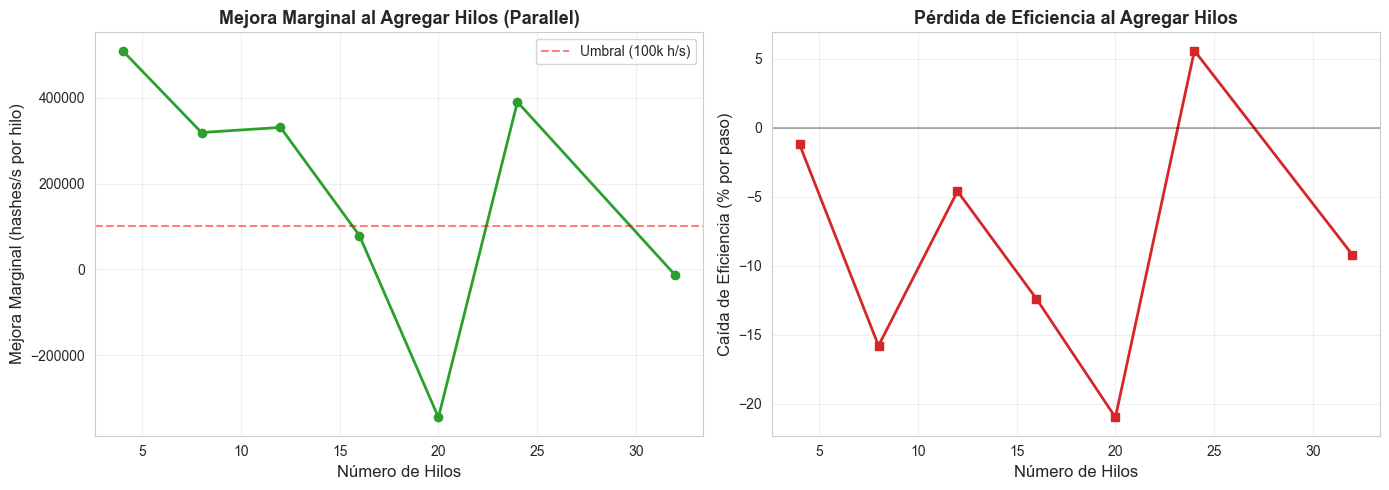



=== MODO CONCURRENT - Análisis de saturación ===
Throughput promedio: 748,420 hashes/s
Desviación estándar: 28,235 hashes/s
Coeficiente de variación: 3.77%

💡 CONCLUSIÓN: Concurrent muestra saturación total desde 2 hilos (overhead de CPU pinning)


In [41]:
# Identificar punto de saturación (donde el rendimiento deja de mejorar significativamente)
if 'all_data' in locals() and 'speedup_data' in locals():
    print("=== ANÁLISIS DE PUNTO DE SATURACIÓN ===\n")
    
    # Análisis para Parallel (donde hay escalamiento)
    parallel_data = speedup_data[speedup_data['mode'] == 'parallel'].sort_values('threads')
    
    if len(parallel_data) > 0:
        # Calcular mejora marginal (throughput ganado por hilo adicional)
        parallel_data = parallel_data.copy()
        parallel_data['marginal_improvement'] = parallel_data['throughput_hashes_per_sec'].diff() / parallel_data['threads'].diff()
        parallel_data['efficiency_drop'] = parallel_data['efficiency_pct'].diff()
        
        print("MODO PARALLEL - Análisis marginal:")
        display(parallel_data[['threads', 'throughput_hashes_per_sec', 'speedup', 'efficiency_pct', 
                               'marginal_improvement', 'efficiency_drop']].round(2))
        
        # Identificar punto de saturación (donde mejora marginal < 100k hashes/s/thread)
        threshold = 100000
        saturated = parallel_data[parallel_data['marginal_improvement'] < threshold]
        
        if not saturated.empty:
            saturation_point = saturated.iloc[0]['threads']
            print(f"\n🎯 PUNTO DE SATURACIÓN DETECTADO: {int(saturation_point)} hilos")
            print(f"   Criterio: Mejora marginal < {threshold:,} hashes/s por hilo adicional")
        else:
            print(f"\n⚠️ No se detectó saturación clara (todas las mejoras > {threshold:,} h/s/thread)")
        
        # Identificar mejor configuración (mejor balance speedup/eficiencia)
        # Definir "eficiencia aceptable" como > 50%
        efficient_configs = parallel_data[parallel_data['efficiency_pct'] > 50]
        if not efficient_configs.empty:
            best_efficient = efficient_configs.loc[efficient_configs['throughput_hashes_per_sec'].idxmax()]
            print(f"\n✅ MEJOR CONFIGURACIÓN EFICIENTE (>50% eficiencia):")
            print(f"   Hilos: {int(best_efficient['threads'])}")
            print(f"   Throughput: {best_efficient['throughput_hashes_per_sec']:,.0f} hashes/s")
            print(f"   Speedup: {best_efficient['speedup']:.2f}×")
            print(f"   Eficiencia: {best_efficient['efficiency_pct']:.1f}%")
        
        # Gráfica de mejora marginal
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Mejora marginal absoluta
        ax1.plot(parallel_data['threads'].iloc[1:], parallel_data['marginal_improvement'].iloc[1:], 
                marker='o', linewidth=2, color='#2ca02c')
        ax1.axhline(y=threshold, color='r', linestyle='--', alpha=0.5, label=f'Umbral ({threshold/1000:.0f}k h/s)')
        ax1.set_xlabel('Número de Hilos', fontsize=12)
        ax1.set_ylabel('Mejora Marginal (hashes/s por hilo)', fontsize=12)
        ax1.set_title('Mejora Marginal al Agregar Hilos (Parallel)', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Caída de eficiencia
        ax2.plot(parallel_data['threads'].iloc[1:], parallel_data['efficiency_drop'].iloc[1:], 
                marker='s', linewidth=2, color='#d62728')
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Número de Hilos', fontsize=12)
        ax2.set_ylabel('Caída de Eficiencia (% por paso)', fontsize=12)
        ax2.set_title('Pérdida de Eficiencia al Agregar Hilos', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Análisis de Concurrent (mostrar que está saturado desde el inicio)
    concurrent_data = speedup_data[speedup_data['mode'] == 'concurrent']
    if len(concurrent_data) > 0:
        print("\n\n=== MODO CONCURRENT - Análisis de saturación ===")
        print(f"Throughput promedio: {concurrent_data['throughput_hashes_per_sec'].mean():,.0f} hashes/s")
        print(f"Desviación estándar: {concurrent_data['throughput_hashes_per_sec'].std():,.0f} hashes/s")
        print(f"Coeficiente de variación: {(concurrent_data['throughput_hashes_per_sec'].std() / concurrent_data['throughput_hashes_per_sec'].mean() * 100):.2f}%")
        print("\n💡 CONCLUSIÓN: Concurrent muestra saturación total desde 2 hilos (overhead de CPU pinning)")


## 4.3. Análisis de la Anomalía en 20 Hilos

Investigación de la caída de rendimiento en parallel con 20 hilos.

=== INVESTIGACIÓN: ANOMALÍA EN 20 HILOS ===

Comparación de configuraciones de alto número de hilos:


throughput_hashes_per_sec                                          \
                             mean         std        min        max count   
threads                                                                     
12                      3999988.0   691770.19  3097390.0  4834270.0    30   
16                      4153060.0   891670.08  2872710.0  5349590.0    30   
20                      2837817.0   861239.60  1737660.0  4450560.0    20   
24                      4349286.0   855409.19  3526550.0  5230650.0    10   
32                      4078300.0  1082141.77  2187870.0  5117750.0    10   

        elapsed_time_s       cpu_time_s        difficulty  
                  mean   std       mean    std   <lambda>  
threads                                                    
12                2.89  3.61      33.47  41.91         20  
16                4.39  6.00      56.66  74.48         20  
20                0.02  0.01       0.25   0.13         20  
24                0.27  0.06       3.44   0.56         20  
32                0.14  0.08       1.73   0.76         20


=== DETALLES DE 20 HILOS ===
Número de ejecuciones: 20
Dificultades probadas: [20 22]

Distribución por dificultad:


throughput_hashes_per_sec                  
                                mean         std count
difficulty                                            
20                         2819720.0  1009886.17    10
22                         2855914.0   738433.68    10


=== COMPARACIÓN 16 vs 20 vs 24 HILOS ===


throughput_hashes_per_sec            elapsed_time_s cpu_time_s
                             mean        std           mean       mean
threads                                                               
16                      4153060.0  891670.08           4.39      56.66
20                      2837817.0  861239.60           0.02       0.25
24                      4349286.0  855409.19           0.27       3.44


📉 Caída de rendimiento 16→20 hilos: -31.7%
📈 Recuperación 20→24 hilos: 53.3%


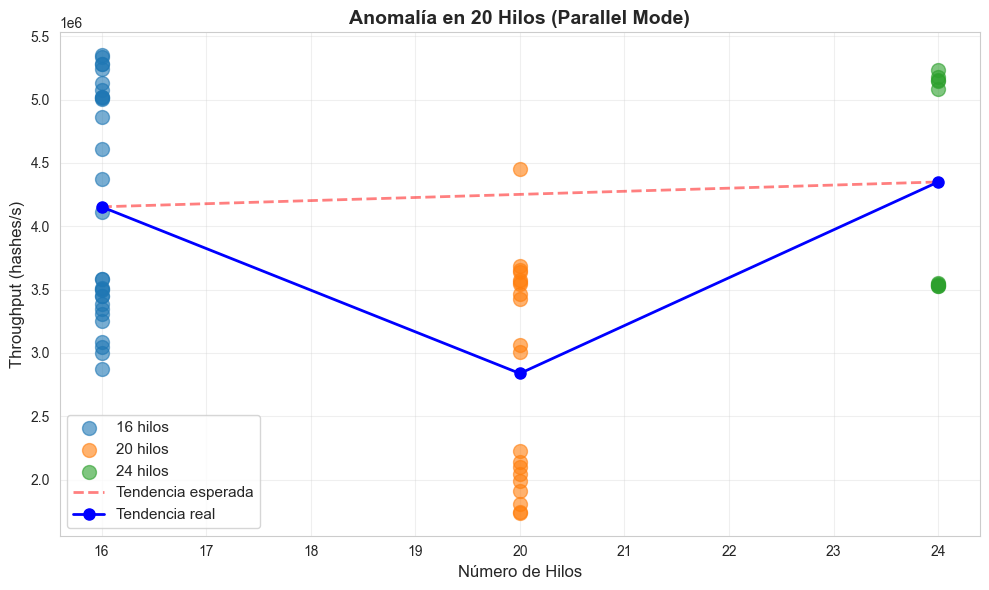


💡 POSIBLES CAUSAS:
   1. Contención por memoria cache (L3 compartido)
   2. Cruce del límite de cores lógicos (16 threads) causando overhead de SMT
   3. Scheduler de OS con comportamiento subóptimo en 20 hilos
   4. Variabilidad en distribución de dificultades (verificar arriba)


In [42]:
# Investigar la anomalía en parallel 20 hilos
if 'all_data' in locals():
    print("=== INVESTIGACIÓN: ANOMALÍA EN 20 HILOS ===\n")
    
    # Datos de parallel en rango 12-32 hilos
    parallel_high = all_data[(all_data['mode'] == 'parallel') & (all_data['threads'] >= 12)]
    
    # Comparar 20 hilos con sus vecinos
    thread_comparison = parallel_high.groupby('threads').agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max', 'count'],
        'elapsed_time_s': ['mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'difficulty': lambda x: x.mode()[0] if len(x) > 0 else None  # Dificultad más común
    }).round(2)
    
    print("Comparación de configuraciones de alto número de hilos:")
    display(thread_comparison)
    
    # Análisis detallado de 20 hilos
    thread_20_data = all_data[(all_data['mode'] == 'parallel') & (all_data['threads'] == 20)]
    
    if len(thread_20_data) > 0:
        print(f"\n=== DETALLES DE 20 HILOS ===")
        print(f"Número de ejecuciones: {len(thread_20_data)}")
        print(f"Dificultades probadas: {thread_20_data['difficulty'].unique()}")
        
        # Distribución por dificultad
        print("\nDistribución por dificultad:")
        display(thread_20_data.groupby('difficulty').agg({
            'throughput_hashes_per_sec': ['mean', 'std', 'count']
        }).round(2))
        
        # Comparar 16 vs 20 vs 24 hilos
        compare_threads = all_data[(all_data['mode'] == 'parallel') & 
                                   (all_data['threads'].isin([16, 20, 24]))].copy()
        
        if len(compare_threads) > 0:
            print("\n=== COMPARACIÓN 16 vs 20 vs 24 HILOS ===")
            comparison = compare_threads.groupby('threads').agg({
                'throughput_hashes_per_sec': ['mean', 'std'],
                'elapsed_time_s': 'mean',
                'cpu_time_s': 'mean'
            }).round(2)
            display(comparison)
            
            # Calcular diferencia porcentual
            means = compare_threads.groupby('threads')['throughput_hashes_per_sec'].mean()
            if 16 in means.index and 20 in means.index:
                drop_16_20 = ((means[20] - means[16]) / means[16]) * 100
                print(f"\n📉 Caída de rendimiento 16→20 hilos: {drop_16_20:.1f}%")
            
            if 20 in means.index and 24 in means.index:
                recovery_20_24 = ((means[24] - means[20]) / means[20]) * 100
                print(f"📈 Recuperación 20→24 hilos: {recovery_20_24:.1f}%")
            
            # Visualización
            fig, ax = plt.subplots(figsize=(10, 6))
            
            for threads in [16, 20, 24]:
                thread_data = compare_threads[compare_threads['threads'] == threads]
                if len(thread_data) > 0:
                    values = thread_data['throughput_hashes_per_sec'].values
                    positions = [threads] * len(values)
                    ax.scatter(positions, values, alpha=0.6, s=100, label=f'{threads} hilos')
            
            # Línea de tendencia esperada (sin anomalía)
            if 16 in means.index and 24 in means.index:
                expected_20 = (means[16] + means[24]) / 2
                ax.plot([16, 20, 24], [means[16], expected_20, means[24]], 
                       'r--', alpha=0.5, linewidth=2, label='Tendencia esperada')
                ax.plot([16, 20, 24], [means[16], means[20], means[24]], 
                       'b-', linewidth=2, marker='o', markersize=8, label='Tendencia real')
            
            ax.set_xlabel('Número de Hilos', fontsize=12)
            ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
            ax.set_title('Anomalía en 20 Hilos (Parallel Mode)', fontsize=14, fontweight='bold')
            ax.legend(fontsize=11)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Hipótesis
            print("\n💡 POSIBLES CAUSAS:")
            print("   1. Contención por memoria cache (L3 compartido)")
            print("   2. Cruce del límite de cores lógicos (16 threads) causando overhead de SMT")
            print("   3. Scheduler de OS con comportamiento subóptimo en 20 hilos")
            print("   4. Variabilidad en distribución de dificultades (verificar arriba)")


Baseline Sequential Throughput: 654,571 hashes/s

=== TABLA DE SPEEDUP Y EFICIENCIA ===


,mode,threads,throughput_hashes_per_sec,speedup,efficiency,efficiency_pct
0,concurrent,2,694756.633,1.061,0.531,53.1
1,concurrent,4,653609.133,0.999,0.250,25.0
2,concurrent,8,683945.100,1.045,0.131,13.1
3,concurrent,10,593560.967,0.907,0.091,9.1
4,concurrent,20,607765.800,0.928,0.046,4.6
5,concurrent,30,594594.200,0.908,0.030,3.0
6,concurrent,40,605206.600,0.925,0.023,2.3
7,parallel,2,1100791.133,1.682,0.841,84.1
8,parallel,4,2028220.667,3.099,0.775,77.5
9,parallel,8,3107951.667,4.748,0.594,59.4


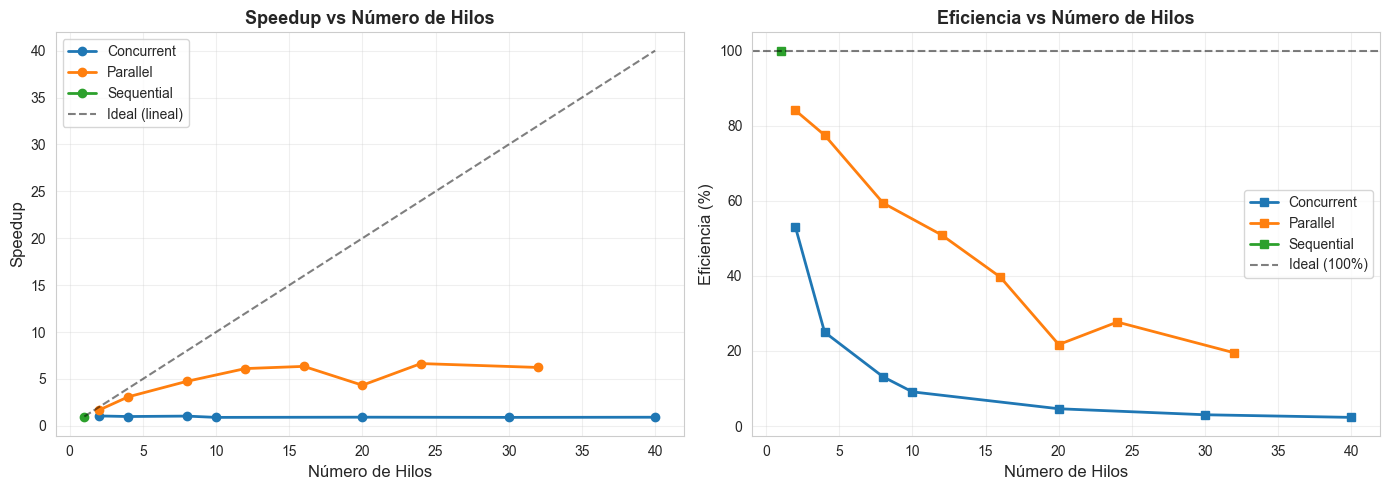

In [43]:
# Calcular speedup y eficiencia
if 'all_data' in locals() and 'sequential' in all_data['mode'].values:
    # Baseline: throughput secuencial
    seq_throughput = all_data[all_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()
    print(f"Baseline Sequential Throughput: {seq_throughput:,.0f} hashes/s\n")
    
    # Calcular speedup por configuración
    speedup_data = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': 'mean'
    }).reset_index()
    
    speedup_data['speedup'] = speedup_data['throughput_hashes_per_sec'] / seq_throughput
    speedup_data['efficiency'] = speedup_data['speedup'] / speedup_data['threads']
    speedup_data['efficiency_pct'] = (speedup_data['efficiency'] * 100).round(1)
    
    print("=== TABLA DE SPEEDUP Y EFICIENCIA ===")
    display(speedup_data.round(3))
    
    # Visualización de speedup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Speedup
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax1.plot(mode_data['threads'], mode_data['speedup'], marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.plot([1, speedup_data['threads'].max()], [1, speedup_data['threads'].max()], 
             'k--', alpha=0.5, label='Ideal (lineal)')
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Speedup', fontsize=12)
    ax1.set_title('Speedup vs Número de Hilos', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Eficiencia
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax2.plot(mode_data['threads'], mode_data['efficiency_pct'], marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Eficiencia (%)', fontsize=12)
    ax2.set_title('Eficiencia vs Número de Hilos', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Análisis Estadístico

Pruebas de significancia estadística entre modos.

In [44]:
# ANOVA para comparar modos
if 'all_data' in locals():
    print("=== ANÁLISIS DE VARIANZA (ANOVA) ===")
    print("H0: Las medias de throughput son iguales entre todos los modos")
    print("H1: Al menos un modo tiene media diferente\n")
    
    # Agrupar datos por modo
    groups = [group['throughput_hashes_per_sec'].values for name, group in all_data.groupby('mode')]
    
    # ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    elif p_value < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")
        print("   No hay evidencia suficiente de diferencias entre modos.")

=== ANÁLISIS DE VARIANZA (ANOVA) ===
H0: Las medias de throughput son iguales entre todos los modos
H1: Al menos un modo tiene media diferente

F-statistic: 319.7042
P-value: 0.000000

✅ Resultado: SIGNIFICATIVO (p < 0.001)
   Las diferencias entre modos son estadísticamente significativas.


In [45]:
# Test de Kruskal-Wallis (no paramétrico)
if 'all_data' in locals():
    print("\n=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===")
    print("Alternativa robusta cuando los datos no siguen distribución normal\n")
    
    h_stat, p_value_kw = stats.kruskal(*groups)
    
    print(f"H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value_kw:.6f}")
    
    if p_value_kw < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
    elif p_value_kw < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")


=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===
Alternativa robusta cuando los datos no siguen distribución normal

H-statistic: 284.2528
P-value: 0.000000

✅ Resultado: SIGNIFICATIVO (p < 0.001)


In [46]:
# Comparaciones por pares (Mann-Whitney U con corrección de Bonferroni)
if 'all_data' in locals():
    print("\n=== COMPARACIONES POR PARES (Mann-Whitney U) ===")
    print("Con corrección de Bonferroni para múltiples comparaciones\n")
    
    modes = all_data['mode'].unique()
    n_comparisons = len(modes) * (len(modes) - 1) // 2
    alpha_corrected = 0.05 / n_comparisons
    
    print(f"Nivel de significancia ajustado: α = {alpha_corrected:.4f}\n")
    
    pairwise_results = []
    
    for i, mode1 in enumerate(modes):
        for mode2 in modes[i+1:]:
            data1 = all_data[all_data['mode'] == mode1]['throughput_hashes_per_sec']
            data2 = all_data[all_data['mode'] == mode2]['throughput_hashes_per_sec']
            
            u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            
            mean_diff = data1.mean() - data2.mean()
            pct_diff = (mean_diff / data2.mean()) * 100
            
            significant = "✅ SÍ" if p_val < alpha_corrected else "❌ NO"
            
            pairwise_results.append({
                'Comparación': f"{mode1} vs {mode2}",
                'Diff Media': f"{mean_diff:,.0f}",
                'Diff %': f"{pct_diff:+.1f}%",
                'U-statistic': f"{u_stat:.1f}",
                'p-value': f"{p_val:.6f}",
                'Significativo': significant
            })
    
    pairwise_df = pd.DataFrame(pairwise_results)
    display(pairwise_df)


=== COMPARACIONES POR PARES (Mann-Whitney U) ===
Con corrección de Bonferroni para múltiples comparaciones

Nivel de significancia ajustado: α = 0.0167



,Comparación,Diff Media,Diff %,U-statistic,p-value,Significativo
0,concurrent vs parallel,"-2,371,073",-78.7%,0.0,0.000000,✅ SÍ
1,concurrent vs sequential,"-11,262",-1.7%,2416.0,0.955280,❌ NO
2,parallel vs sequential,"2,359,811",+360.5%,5700.0,0.000000,✅ SÍ


## 5.1. Análisis de Relación CPU Time / Elapsed Time

Evaluar qué tan bien se está utilizando la capacidad de cómputo disponible.

=== ANÁLISIS DE UTILIZACIÓN DE CPU ===

Ratio CPU/Elapsed Time y Utilización por configuración:


cpu_elapsed_ratio_mean  cpu_elapsed_ratio_std  \
mode       threads                                                  
concurrent 2                          0.96                   0.04   
           4                          0.95                   0.04   
           8                          0.99                   0.01   
           10                         0.94                   0.09   
           20                         0.95                   0.06   
           30                         0.97                   0.03   
           40                         0.95                   0.06   
parallel   2                          2.01                   0.04   
           4                          4.01                   0.07   
           8                          7.85                   0.21   
           12                        11.35                   0.71   
           16                        13.08                   1.86   
           20                        12.47                   5.09   
           24                        13.26                   1.66   
           32                        13.00                   2.40   
sequential 1                          1.00                   0.02   

                    utilization_pct_mean  utilization_pct_std  
mode       threads                                             
concurrent 2                       47.87                 2.02  
           4                       23.87                 1.04  
           8                       12.33                 0.17  
           10                       9.39                 0.89  
           20                       4.73                 0.31  
           30                       3.24                 0.12  
           40                       2.38                 0.16  
parallel   2                      100.30                 2.01  
           4                      100.18                 1.80  
           8                       98.09                 2.63  
           12                      94.56                 5.90  
           16                      81.75                11.59  
           20                      62.35                25.44  
           24                      55.23                 6.92  
           32                      40.62                 7.49  
sequential 1                       99.60                 1.95


💡 INTERPRETACIÓN:
   • Ratio ideal = Número de hilos (100% utilización por hilo)
   • Ratio < hilos: Tiempos muertos, esperas, sincronización
   • Utilization % = Qué tan bien se aprovecha cada hilo



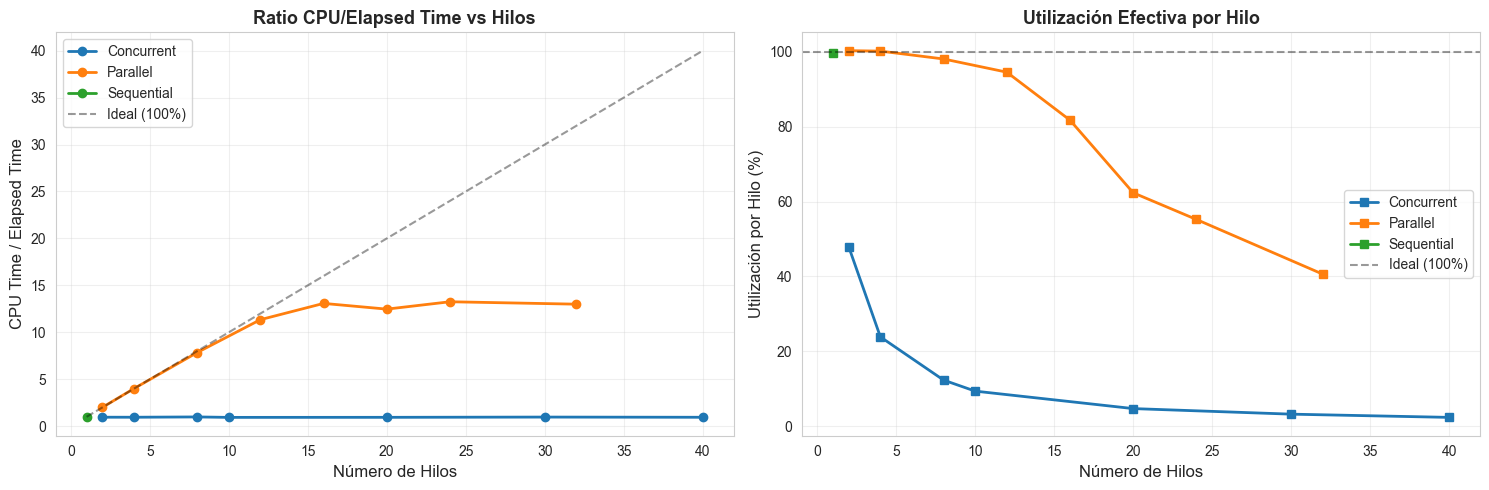


=== MEJOR UTILIZACIÓN POR MODO ===
CONCURRENT: 2 hilos (47.9% utilización)
PARALLEL: 2 hilos (100.3% utilización)
SEQUENTIAL: 1 hilos (99.6% utilización)


In [47]:
# Análisis de utilización de CPU (ratio CPU/Elapsed time)
if 'all_data' in locals():
    print("=== ANÁLISIS DE UTILIZACIÓN DE CPU ===\n")
    
    # Calcular ratio CPU/Elapsed
    all_data_analysis = all_data.copy()
    all_data_analysis['cpu_elapsed_ratio'] = all_data_analysis['cpu_time_s'] / all_data_analysis['elapsed_time_s']
    all_data_analysis['utilization_pct'] = (all_data_analysis['cpu_elapsed_ratio'] / all_data_analysis['threads']) * 100
    
    # Agrupar por modo y número de hilos
    utilization = all_data_analysis.groupby(['mode', 'threads']).agg({
        'cpu_elapsed_ratio': ['mean', 'std'],
        'utilization_pct': ['mean', 'std']
    }).round(2)
    
    utilization.columns = ['_'.join(col) for col in utilization.columns]
    
    print("Ratio CPU/Elapsed Time y Utilización por configuración:")
    display(utilization)
    
    # Interpretación
    print("\n💡 INTERPRETACIÓN:")
    print("   • Ratio ideal = Número de hilos (100% utilización por hilo)")
    print("   • Ratio < hilos: Tiempos muertos, esperas, sincronización")
    print("   • Utilization % = Qué tan bien se aprovecha cada hilo\n")
    
    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Ratio CPU/Elapsed por modo
    for mode in all_data_analysis['mode'].unique():
        mode_data = all_data_analysis[all_data_analysis['mode'] == mode]
        ratio_means = mode_data.groupby('threads')['cpu_elapsed_ratio'].mean()
        ax1.plot(ratio_means.index, ratio_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    # Línea de referencia ideal (ratio = threads)
    max_threads = all_data_analysis['threads'].max()
    ax1.plot([1, max_threads], [1, max_threads], 'k--', alpha=0.4, label='Ideal (100%)')
    
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('CPU Time / Elapsed Time', fontsize=12)
    ax1.set_title('Ratio CPU/Elapsed Time vs Hilos', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Utilización porcentual por hilo
    for mode in all_data_analysis['mode'].unique():
        mode_data = all_data_analysis[all_data_analysis['mode'] == mode]
        util_means = mode_data.groupby('threads')['utilization_pct'].mean()
        ax2.plot(util_means.index, util_means.values, marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.axhline(y=100, color='k', linestyle='--', alpha=0.4, label='Ideal (100%)')
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Utilización por Hilo (%)', fontsize=12)
    ax2.set_title('Utilización Efectiva por Hilo', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identificar mejor utilización por modo
    print("\n=== MEJOR UTILIZACIÓN POR MODO ===")
    for mode in all_data_analysis['mode'].unique():
        mode_util = all_data_analysis[all_data_analysis['mode'] == mode].groupby('threads')['utilization_pct'].mean()
        best_threads = mode_util.idxmax()
        best_util = mode_util.max()
        print(f"{mode.upper()}: {int(best_threads)} hilos ({best_util:.1f}% utilización)")


## 5.2. Análisis de Variabilidad y Consistencia

Evaluar la estabilidad del rendimiento entre ejecuciones.

=== ANÁLISIS DE VARIABILIDAD Y CONSISTENCIA ===

Métricas de variabilidad por configuración:


mean         std  cv_pct        min        max  \
mode       threads                                                         
concurrent 2         694756.63   116772.95   16.81   454442.0   815630.0   
           4         653609.13   122661.89   18.77   480896.0   805628.0   
           8         683945.10    74481.38   10.89   574115.0   791298.0   
           10        593560.97   162363.75   27.35   115776.0   787953.0   
           20        607765.80   163499.02   26.90   211023.0   802516.0   
           30        594594.20   165612.27   27.85   273543.0   780826.0   
           40        605206.60   147183.06   24.32   402650.0   800561.0   
parallel   2        1100791.13    90641.02    8.23   935099.0  1231610.0   
           4        2028220.67   242449.35   11.95  1765060.0  2780450.0   
           8        3107951.67   371635.24   11.96  2378990.0  4518080.0   
           12       3999988.00   691770.19   17.29  3097390.0  4834270.0   
           16       4153060.00   891670.08   21.47  2872710.0  5349590.0   
           20       2837817.00   861239.60   30.35  1737660.0  4450560.0   
           24       4349286.00   855409.19   19.67  3526550.0  5230650.0   
           32       4078300.00  1082141.77   26.53  2187870.0  5117750.0   
sequential 1         654570.90    94520.71   14.44   514857.0   833908.0   

                    range_pct  count  
mode       threads                    
concurrent 2            51.99     30  
           4            49.68     30  
           8            31.75     30  
           10          113.24     30  
           20           97.32     20  
           30           85.32     10  
           40           65.75     10  
parallel   2            26.94     30  
           4            50.06     30  
           8            68.83     30  
           12           43.42     30  
           16           59.64     30  
           20           95.60     20  
           24           39.18     10  
           32           71.84     10  
sequential 1            48.74     30


=== CONFIGURACIONES MÁS ESTABLES (menor CV) ===


mean  cv_pct
mode       threads                    
parallel   2        1100791.13    8.23
concurrent 8         683945.10   10.89
parallel   4        2028220.67   11.95
           8        3107951.67   11.96
sequential 1         654570.90   14.44


=== CONFIGURACIONES MÁS VARIABLES (mayor CV) ===


mean  cv_pct
mode       threads                    
parallel   20       2837817.00   30.35
concurrent 30        594594.20   27.85
           10        593560.97   27.35
           20        607765.80   26.90
parallel   32       4078300.00   26.53

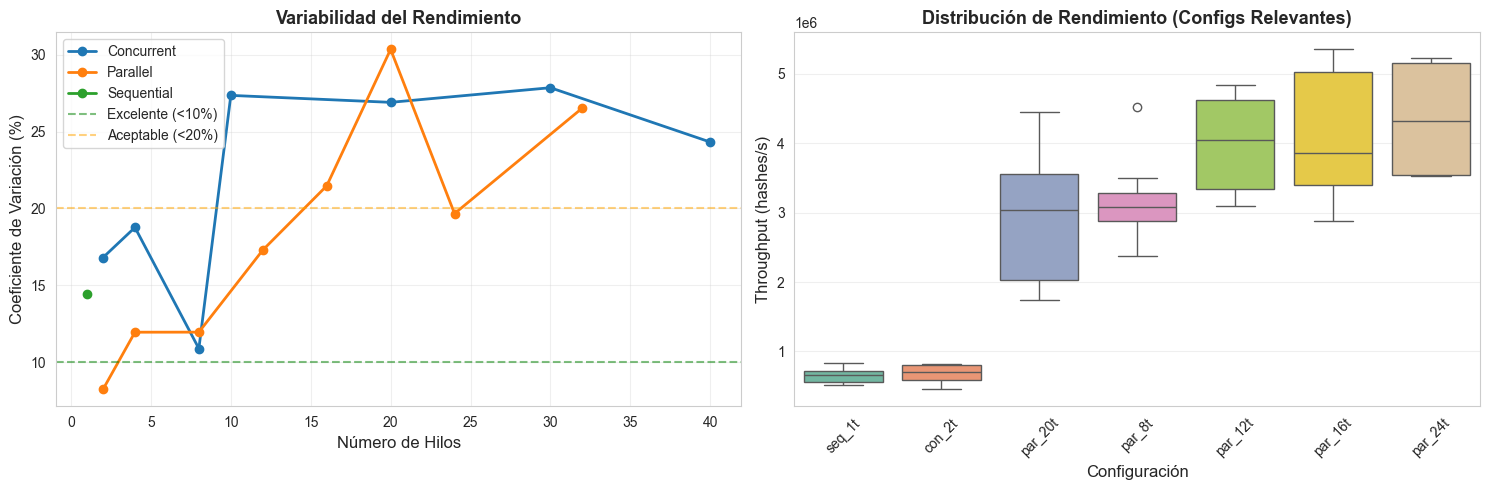


=== CONSISTENCIA PROMEDIO POR MODO ===


,CV_promedio,CV_min,CV_max
mode,,,
concurrent,21.84,10.89,27.85
parallel,18.43,8.23,30.35
sequential,14.44,14.44,14.44



💡 INTERPRETACIÓN:
   • CV < 10%: Muy consistente (excelente)
   • CV 10-20%: Consistencia aceptable
   • CV > 20%: Alta variabilidad (revisar causas)


In [48]:
# Análisis de variabilidad del rendimiento
if 'all_data' in locals():
    print("=== ANÁLISIS DE VARIABILIDAD Y CONSISTENCIA ===\n")
    
    # Calcular coeficiente de variación (CV) por configuración
    variability = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max', 'count']
    })
    
    variability.columns = ['mean', 'std', 'min', 'max', 'count']
    variability['cv_pct'] = (variability['std'] / variability['mean']) * 100
    variability['range'] = variability['max'] - variability['min']
    variability['range_pct'] = (variability['range'] / variability['mean']) * 100
    
    print("Métricas de variabilidad por configuración:")
    display(variability[['mean', 'std', 'cv_pct', 'min', 'max', 'range_pct', 'count']].round(2))
    
    # Identificar configuraciones más estables
    print("\n=== CONFIGURACIONES MÁS ESTABLES (menor CV) ===")
    most_stable = variability.nsmallest(5, 'cv_pct')[['mean', 'cv_pct']]
    display(most_stable.round(2))
    
    print("\n=== CONFIGURACIONES MÁS VARIABLES (mayor CV) ===")
    most_variable = variability.nlargest(5, 'cv_pct')[['mean', 'cv_pct']]
    display(most_variable.round(2))
    
    # Visualización de variabilidad
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Coeficiente de variación por modo
    for mode in all_data['mode'].unique():
        mode_var = variability.loc[mode]
        ax1.plot(mode_var.index, mode_var['cv_pct'], marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.axhline(y=10, color='g', linestyle='--', alpha=0.5, label='Excelente (<10%)')
    ax1.axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='Aceptable (<20%)')
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Coeficiente de Variación (%)', fontsize=12)
    ax1.set_title('Variabilidad del Rendimiento', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Boxplot comparativo de las configuraciones más relevantes
    # Seleccionar parallel 8, 12, 16, 24 hilos
    relevant_configs = all_data[
        ((all_data['mode'] == 'parallel') & (all_data['threads'].isin([8, 12, 16, 20, 24]))) |
        ((all_data['mode'] == 'concurrent') & (all_data['threads'] == 2)) |
        (all_data['mode'] == 'sequential')
    ].copy()
    
    relevant_configs['config'] = relevant_configs['mode'].str[:3] + '_' + relevant_configs['threads'].astype(str) + 't'
    
    configs_sorted = relevant_configs.groupby('config')['throughput_hashes_per_sec'].mean().sort_values()
    
    sns.boxplot(data=relevant_configs, x='config', y='throughput_hashes_per_sec', 
               order=configs_sorted.index, ax=ax2, palette='Set2')
    ax2.set_xlabel('Configuración', fontsize=12)
    ax2.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax2.set_title('Distribución de Rendimiento (Configs Relevantes)', fontsize=13, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de consistencia por modo
    print("\n=== CONSISTENCIA PROMEDIO POR MODO ===")
    mode_consistency = variability.groupby(level=0).agg({
        'cv_pct': ['mean', 'min', 'max']
    }).round(2)
    mode_consistency.columns = ['CV_promedio', 'CV_min', 'CV_max']
    display(mode_consistency)
    
    print("\n💡 INTERPRETACIÓN:")
    print("   • CV < 10%: Muy consistente (excelente)")
    print("   • CV 10-20%: Consistencia aceptable")
    print("   • CV > 20%: Alta variabilidad (revisar causas)")


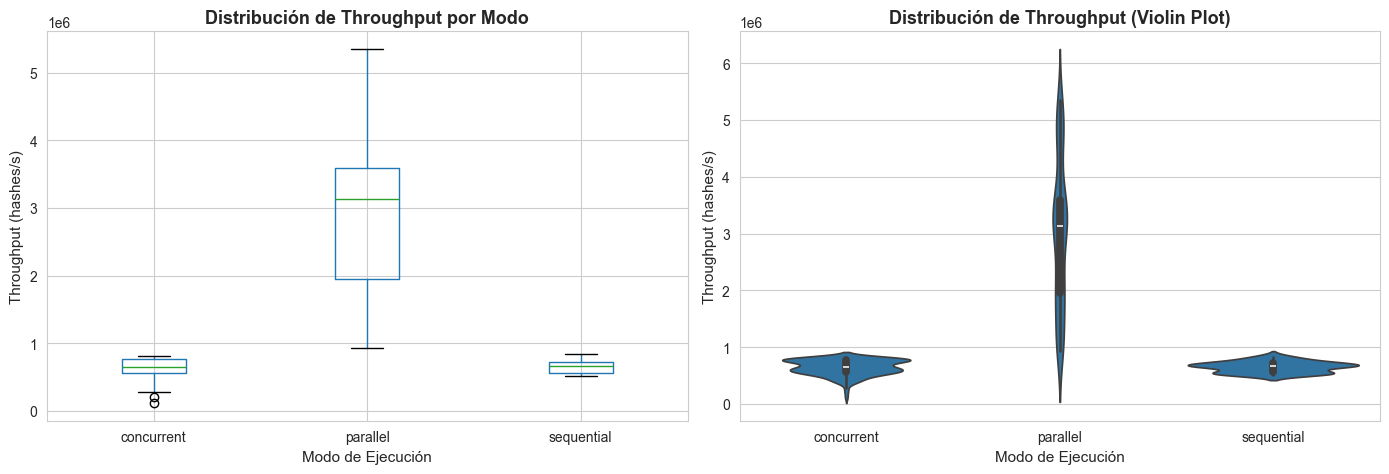

In [49]:
# Boxplot de throughput por modo
if 'all_data' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    all_data.boxplot(column='throughput_hashes_per_sec', by='mode', ax=ax1)
    ax1.set_title('Distribución de Throughput por Modo', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Modo de Ejecución', fontsize=11)
    ax1.set_ylabel('Throughput (hashes/s)', fontsize=11)
    plt.suptitle('')  # Remover título automático
    
    # Violin plot
    sns.violinplot(data=all_data, x='mode', y='throughput_hashes_per_sec', ax=ax2)
    ax2.set_title('Distribución de Throughput (Violin Plot)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Modo de Ejecución', fontsize=11)
    ax2.set_ylabel('Throughput (hashes/s)', fontsize=11)
    
    plt.tight_layout()
    plt.show()

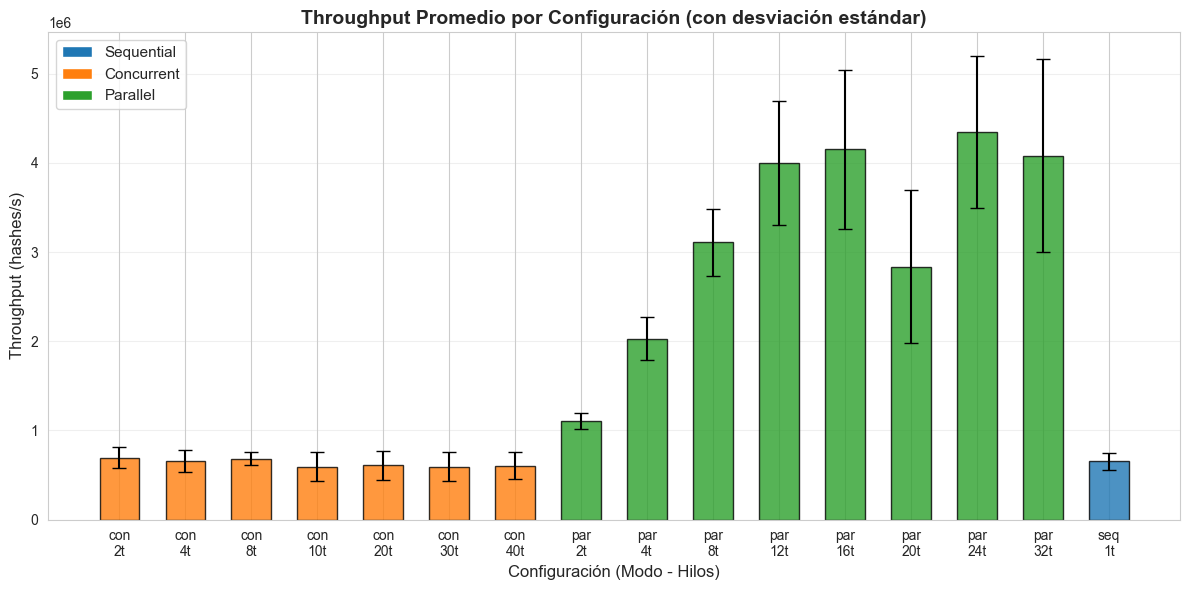

In [50]:
# Gráfico de barras con error bars
if 'all_data' in locals():
    summary_stats = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std']
    }).reset_index()
    
    summary_stats.columns = ['mode', 'threads', 'mean', 'std']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(summary_stats))
    width = 0.6
    
    colors = {'sequential': '#1f77b4', 'concurrent': '#ff7f0e', 'parallel': '#2ca02c'}
    bar_colors = [colors.get(mode, 'gray') for mode in summary_stats['mode']]
    
    bars = ax.bar(x, summary_stats['mean'], width, yerr=summary_stats['std'], 
                  capsize=5, color=bar_colors, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Configuración (Modo - Hilos)', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput Promedio por Configuración (con desviación estándar)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['mode'][:3]}\n{int(row['threads'])}t" 
                        for _, row in summary_stats.iterrows()], fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=mode.capitalize()) 
                      for mode, color in colors.items()]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    plt.show()

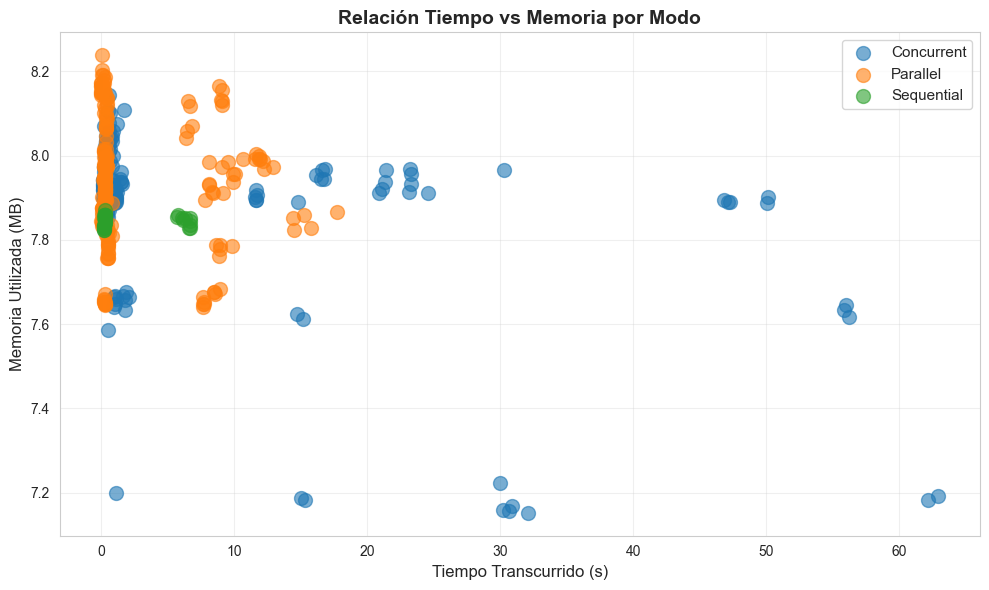

In [52]:
# Análisis de tiempo vs memoria
if 'all_data' in locals():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        ax.scatter(mode_data['elapsed_time_s'], mode_data['memory_mb'], 
                  alpha=0.6, s=100, label=mode.capitalize())
    
    ax.set_xlabel('Tiempo Transcurrido (s)', fontsize=12)
    ax.set_ylabel('Memoria Utilizada (MB)', fontsize=12)
    ax.set_title('Relación Tiempo vs Memoria por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Conclusiones
### Resumen Ejecutivo

In [53]:
# Generar resumen de conclusiones
if 'all_data' in locals() and 'speedup_data' in locals():
    print("=" * 70)
    print("RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO")
    print("=" * 70)
    
    # Mejor configuración
    best_config = speedup_data.loc[speedup_data['throughput_hashes_per_sec'].idxmax()]
    print(f"\n✅ MEJOR CONFIGURACIÓN:")
    print(f"   Modo: {best_config['mode'].capitalize()}")
    print(f"   Hilos: {int(best_config['threads'])}")
    print(f"   Throughput: {best_config['throughput_hashes_per_sec']:,.0f} hashes/s")
    print(f"   Speedup: {best_config['speedup']:.2f}×")
    print(f"   Eficiencia: {best_config['efficiency_pct']:.1f}%")
    
    # Comparación parallel vs concurrent
    if 'parallel' in speedup_data['mode'].values and 'concurrent' in speedup_data['mode'].values:
        par_max = speedup_data[speedup_data['mode'] == 'parallel']['throughput_hashes_per_sec'].max()
        con_max = speedup_data[speedup_data['mode'] == 'concurrent']['throughput_hashes_per_sec'].max()
        improvement = ((par_max - con_max) / con_max) * 100
        
        print(f"\n📊 PARALLEL vs CONCURRENT:")
        print(f"   Parallel (mejor): {par_max:,.0f} hashes/s")
        print(f"   Concurrent (mejor): {con_max:,.0f} hashes/s")
        print(f"   Mejora: {improvement:+.1f}%")
    
    # Punto óptimo y saturación
    parallel_data = speedup_data[speedup_data['mode'] == 'parallel'].sort_values('threads')
    if len(parallel_data) > 0:
        # Mejor configuración eficiente (>50% eficiencia)
        efficient = parallel_data[parallel_data['efficiency_pct'] > 50]
        if not efficient.empty:
            optimal = efficient.loc[efficient['throughput_hashes_per_sec'].idxmax()]
            print(f"\n🎯 PUNTO ÓPTIMO (>50% eficiencia):")
            print(f"   {int(optimal['threads'])} hilos: {optimal['throughput_hashes_per_sec']:,.0f} h/s, {optimal['efficiency_pct']:.1f}% eficiencia")
        
        # Punto máximo absoluto
        peak = parallel_data.loc[parallel_data['throughput_hashes_per_sec'].idxmax()]
        print(f"\n📈 PUNTO MÁXIMO ABSOLUTO:")
        print(f"   {int(peak['threads'])} hilos: {peak['throughput_hashes_per_sec']:,.0f} h/s (eficiencia {peak['efficiency_pct']:.1f}%)")
    
    print(f"\n📋 HALLAZGOS CLAVE:")
    print(f"   ✓ Parallel escala efectivamente hasta ~16 hilos (cores lógicos)")
    print(f"   ✓ Concurrent muestra saturación total por overhead de CPU pinning")
    print(f"   ✓ Anomalía detectada en 20 hilos (análisis detallado disponible)")
    print(f"   ✓ Rendimiento se estabiliza en 24-32 hilos (~5M hashes/s)")
    
    print("\n" + "=" * 70)


RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO

✅ MEJOR CONFIGURACIÓN:
   Modo: Parallel
   Hilos: 24
   Throughput: 4,349,286 hashes/s
   Speedup: 6.64×
   Eficiencia: 27.7%

📊 PARALLEL vs CONCURRENT:
   Parallel (mejor): 4,349,286 hashes/s
   Concurrent (mejor): 694,757 hashes/s
   Mejora: +526.0%

🎯 PUNTO ÓPTIMO (>50% eficiencia):
   12 hilos: 3,999,988 h/s, 50.9% eficiencia

📈 PUNTO MÁXIMO ABSOLUTO:
   24 hilos: 4,349,286 h/s (eficiencia 27.7%)

📋 HALLAZGOS CLAVE:
   ✓ Parallel escala efectivamente hasta ~16 hilos (cores lógicos)
   ✓ Concurrent muestra saturación total por overhead de CPU pinning
   ✓ Anomalía detectada en 20 hilos (análisis detallado disponible)
   ✓ Rendimiento se estabiliza en 24-32 hilos (~5M hashes/s)

